# Deep Learning - Homework 03

### Roberto Corti

In [1]:
### GOOGLE DRIVE 

from google.colab import drive

folder_mount = '/content/drive' # Your Drive will be mounted on top of this path

drive.mount(folder_mount)

%cd drive/MyDrive/Università/DSSC/Secondo\ Anno/Deep-Learning/homeworks/

Mounted at /content/drive
/content/drive/MyDrive/Università/DSSC/Secondo Anno/Deep-Learning/homeworks


### 1. Implement L1 norm regularization as a custom loss function

In [2]:
import torch
import torch.nn as nn
import torchvision
import numpy as np
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor, Normalize, Compose

In [3]:
# Fully connected neural network with 3 hidden layers, inputsize=28*28, output
class MLP(nn.Module):
  '''
  Fully connected neural network with 3 hidden layers.
  Input size: 784
  Output size: 10
  '''
  def __init__(self):
    super().__init__()
    self.flat = nn.Flatten()
    self.h1 = nn.Linear(28*28, 16)
    self.h2 = nn.Linear(16, 32)
    self.h3 = nn.Linear(32, 24)
    self.out = nn.Linear(24, 10)
    
  def forward(self, X, activ_hidden=nn.functional.relu):
    out = self.flat(X)
    out = activ_hidden(self.h1(out))
    out = activ_hidden(self.h2(out))
    out = activ_hidden(self.h3(out))
    out = self.out(out)
    return out

In [4]:
# https://stackoverflow.com/questions/66646604/http-error-503-service-unavailable-whan-trying-to-download-mnist-data
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters 
minibatch_size_train = 256
minibatch_size_test = 512
learning_rate = 0.01

# Trasformations
transforms = Compose([
                      ToTensor(),
                      Normalize((0.1307,), (0.3081,))
                    ])

# MNIST dataset 
train_dataset = torchvision.datasets.MNIST(root='./data', 
                                           train=True, 
                                           transform=transforms,  
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='./data', 
                                          train=False, 
                                          transform=transforms)



# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=minibatch_size_train, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=minibatch_size_test, 
                                          shuffle=False)


--2021-04-11 13:27:10--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2021-04-11 13:27:10--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘MNIST.tar.gz.4’

MNIST.tar.gz.4          [               <=>  ]  33.20M  3.55MB/s    in 9.8s    

2021-04-11 13:27:20 (3.38 MB/s) - ‘MNIST.tar.gz.4’ saved [34813078]

MNIST/
MNIST/raw/
MNIST/raw/train-labels-idx1-ubyte
MNIST/raw/t10k-labels-idx1-ubyte.gz
MNIST/raw/t10k-labels-idx1-ubyte
MNIST/raw/t10k-images-idx3-ubyte.gz
MNIST/raw/train-images-idx3-ubyte
MNIST/raw/train-labels-idx1-ubyte.gz
MNIST/raw/t10k-images-idx3-ubyte
MNIST/raw

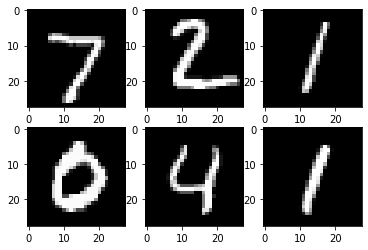

In [5]:
examples = iter(test_loader)
example_data, example_targets = examples.next()

for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(example_data[i][0], cmap='gray')
plt.show()

In [6]:
# Model
model = MLP().to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

# Number of epochs
num_epochs = 50

# Train the model
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        # origin shape: [100, 1, 28, 28]
        # resized: [100, 784]
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Adding L1 penalty
        l1_lambda = 0.001
        l1_norm = sum(p.abs().sum() 
                         for p in model.parameters())
        loss = loss + l1_lambda * l1_norm
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')


# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs.data, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the 10000 test images: {acc} %')


Epoch [1/50], Step [100/235], Loss: 0.7075
Epoch [1/50], Step [200/235], Loss: 0.6002
Epoch [2/50], Step [100/235], Loss: 0.6411
Epoch [2/50], Step [200/235], Loss: 0.6248
Epoch [3/50], Step [100/235], Loss: 0.6721
Epoch [3/50], Step [200/235], Loss: 0.5890
Epoch [4/50], Step [100/235], Loss: 0.5726
Epoch [4/50], Step [200/235], Loss: 0.5697
Epoch [5/50], Step [100/235], Loss: 0.5422
Epoch [5/50], Step [200/235], Loss: 0.6351
Epoch [6/50], Step [100/235], Loss: 0.5743
Epoch [6/50], Step [200/235], Loss: 0.5759
Epoch [7/50], Step [100/235], Loss: 0.6375
Epoch [7/50], Step [200/235], Loss: 0.5507
Epoch [8/50], Step [100/235], Loss: 0.6872
Epoch [8/50], Step [200/235], Loss: 0.5670
Epoch [9/50], Step [100/235], Loss: 0.5825
Epoch [9/50], Step [200/235], Loss: 0.5099
Epoch [10/50], Step [100/235], Loss: 0.6691
Epoch [10/50], Step [200/235], Loss: 0.5979
Epoch [11/50], Step [100/235], Loss: 0.6217
Epoch [11/50], Step [200/235], Loss: 0.6035
Epoch [12/50], Step [100/235], Loss: 0.4677
Epoch 

### 2. Implement early stopping in the $E_{\text{opt}}$ specification


To describe the criteria, let $E$ be the loss function of the training algorithm and let $E_{val}(t)$ the validation error at epoch $t$. The value $E_{opt}(t)$ is defined to be the lowest validation set error obtained up to $t$.:

$$ E_{opt}(t) := \min_{t' \le t} E_{val}(t')$$

The generalization loss at epoch $t$ the relative increase of the validation error over the minimum so-far:

$$ GL(t) := 100 \cdot \biggl( \frac{E_{val}(t)}{E_{opt}(t)} -1 \biggr)$$

The first class of stopping criteria defined in [Prechelt, L. (1998)](https://page.mi.fu-berlin.de/prechelt/Biblio/stop_tricks1997.pdf) is the following:

$$ GL_{\alpha}: \text{stop training at first epoch for which} \space GL(t) > \alpha $$

that is, stop as soon as the generalization loss exceeds a certain threshold.

In order to have this criteria we need to evaluate $E_{val}(t)$ at each epoch of the training:

In [ ]:
def validation_error(test_loader, model, criterion, test_batch_size, device):
  with torch.no_grad():
    loss = 0
    for x_test, y_test in test_loader:
      x_test = x_test.to(device)
      y_test = y_test.to(device)
      y_hat = model(x_test)
      loss_batch = criterion(y_hat, y_test)
      loss += loss_batch

    return loss.item() / len(test_loader)

Once provided such function the criteria can be implemented in our training loop by adding these following steps:

```python
for epoch in range(num_epochs):

  # training step

  # evaluate E_val(epoch)

  # evaluate E_opt(epoch)

  # evaluate GL(epoch)

  # check stop criteria 
```


In [ ]:
# Model
model = MLP().to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

# Number of epochs
num_epochs = 50

# initialize E_opt
E_opt = np.inf

# early stopping parameter
alpha = 5

# Train the model
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        # origin shape: [100, 1, 28, 28]
        # resized: [100, 784]
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) == minibatch_size_train // 2:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

    # evaluate E_val (epoch)
    E_val = validation_error(test_loader, model, criterion, minibatch_size_test, device)

    # evaluate E_opt (epoch)
    if E_opt > E_val:
      E_opt = E_val

    # compute GL (epoch)
    GL = 100 * ( (E_val/E_opt)-1)

    print(f'Epoch [{epoch+1}/{num_epochs}], E_val: {E_val:.4f}, E_opt: {E_opt:.4f}, GL: {GL:.3f}')

    # apply criterion GL_alpha
    if GL > alpha:
      break

Epoch [1/50], Step [128/235], Loss: 0.3249
Epoch [1/50], E_val: 0.2128, E_opt: 0.2128, GL: 0.000
Epoch [2/50], Step [128/235], Loss: 0.2114
Epoch [2/50], E_val: 0.2308, E_opt: 0.2128, GL: 8.433


In [ ]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs.data, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the 10000 test images: {acc} %')

Accuracy of the network on the 10000 test images: 93.13 %


### 3. Try implementing Correct Class Quadratic Loss (CCQL) ([Demirkaya et al.](https://intra.ece.ucr.edu/~oymak/multiclass.pdf) ) in PyTorch

Given an input $\bf{x}$, the model prediction $f(\bf{x})$ the Correct-Class Quadratic-Loss (CCQL) is defined as

$$ \mathcal{L}_{CCQL}(f, \mathcal{D}) = \mathcal{L}_{QL}(f, \mathcal{D}) + \frac{w}{2} \mathbb{E} [(1-f(\mathbf{x})^2] $$

where $\mathcal{L}_{QL}(f, \mathcal{D})$ is the quadratic loss.

As suggested in the paper, I decide to pick $w = \sqrt{K-1} - 1$, where $K$ specifies the number of classes. 

In [77]:
class CCQLOSS(nn.Module):
  def __init__(self, weight=None, size_average=True):
    super(CCQLOSS, self).__init__()

  def forward(self, outputs, labels, num_classes):
    '''
    Computes Correct Class Quadratic Loss.
    outputs: output of the model on the observations
    labels: expected output labels of the observations
    num_classes: number of classes of the data
    '''
    outputs=torch.nn.functional.softmax(outputs, dim=1)
    one_hot_labels = nn.functional.one_hot(labels).float()
    QLoss = nn.MSELoss()
    QL = QLoss(outputs, one_hot_labels)
    w = np.sqrt(num_classes-1)-1
    CTerm = (w/2) * torch.tensor([(1-outputs[i, labels[i]])**2 for i in range(0, len(labels))]).mean()
    return QL + CTerm

In [78]:
# Number of classes
num_classes = len(train_dataset.classes)
# Model
model = MLP().to(device)

# Loss and optimizer
criterion = CCQLOSS()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

# Number of epochs
num_epochs = 50

# Train the model
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        # origin shape: [100, 1, 28, 28]
        # resized: [100, 784]
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels, num_classes)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')


# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs.data, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the 10000 test images: {acc} %')


Epoch [1/50], Step [100/235], Loss: 0.1597
Epoch [1/50], Step [200/235], Loss: 0.0955
Epoch [2/50], Step [100/235], Loss: 0.0787
Epoch [2/50], Step [200/235], Loss: 0.0565
Epoch [3/50], Step [100/235], Loss: 0.0669
Epoch [3/50], Step [200/235], Loss: 0.0634
Epoch [4/50], Step [100/235], Loss: 0.0621
Epoch [4/50], Step [200/235], Loss: 0.0877
Epoch [5/50], Step [100/235], Loss: 0.0501
Epoch [5/50], Step [200/235], Loss: 0.0631
Epoch [6/50], Step [100/235], Loss: 0.0541
Epoch [6/50], Step [200/235], Loss: 0.0663
Epoch [7/50], Step [100/235], Loss: 0.0461
Epoch [7/50], Step [200/235], Loss: 0.0540
Epoch [8/50], Step [100/235], Loss: 0.0601
Epoch [8/50], Step [200/235], Loss: 0.0693
Epoch [9/50], Step [100/235], Loss: 0.0296
Epoch [9/50], Step [200/235], Loss: 0.0688
Epoch [10/50], Step [100/235], Loss: 0.0631
Epoch [10/50], Step [200/235], Loss: 0.0859
Epoch [11/50], Step [100/235], Loss: 0.0660
Epoch [11/50], Step [200/235], Loss: 0.0472
Epoch [12/50], Step [100/235], Loss: 0.0664
Epoch 